In [1]:
"""
https://tradingstrategyguides.com/swing-trading-strategies-that-work/

It's based on classic technical indicator called "Bollinger Bands". It's construced as:
- central moving average (MA), which is a simple moving average.
- two other moving averages at a distance of +-2 standard dev. away from the central MA

There are following steps:
#1: Wait for the price to touch the Upper Bollinger Band. It (in theory) means that price is price moving into 
overbought territory. That is - price is relatively too high for given stock and will probably go down.

Step #2: Wait for the price to Break below the Middle Bollinger Bands. Such a move acts as confirmation of the 
shift in market sentiment. In other words - investors realized that stock is overbought and started seeling
(hence price is going down).

Important Note: the "breakout" of the central MA should be so called "Big Bold Breakout Candle". That is
closing price is near the Low Range of the Candlestick. One should sell at the closing price of the Breakout Candle.

This "Breakout Candle" is meant to confirm that there are real sellers, that is: there is an assumption that such a
strong move down indicates actual changed sentiment of sellers rather that just its the "natural" fluctation 
of the price.

Step #4: Set-up "Protective Stop Loss" above the Breakout Candle
As a stop loss high of the entry candle is taken. Rationalities behind it is that during entry move one assumes 
candle as representation of real market sentiment and sellers. If high of this candle is "broken" that is
clear sign that in this case there was no real sellers sentiment shift.

Step #5: Take Profit once we break and close back above the middle Bollinger Bands (central MA)

THAT WAS SHORT TRADE EXAMPLE. FOR LONG TRADES THERE ARE SAME STEPS BUT IN REVERSED ORDER

My personal thought:
- It would be nice to have some sort of expected range of the move. That is - one is setting up stop loss which is 
fine, but at the same time there is no expected range of the move in preferable direction. That makes calculating
reward-to-risk ratio imposibble.
- If one have multiple trades to choose (and properly diversify portfolio) then given strategy gives no clues about
which trade choose. R2R ratio would be helpfull.
- That problem occures not only when we have couple of trades to choose in the same day. One can "loose" future trade
by choosing the one today - which in reality one is not aware of having small R2RR.
- Having method to estimate R2RR and uses it as an additional filter for trades could be good enhacemnet for that
strategy.

""";

In [64]:
# built-in
import sys
sys.path.insert(0, '/Users/slaw/osobiste/trading')

# custom
import gpw_data

%matplotlib notebook  # to allow zoom plots

In [31]:
import importlib
importlib.reload(gpw_data)

<module 'gpw_data' from '/Users/slaw/osobiste/trading/gpw_data.py'>

In [32]:
gpwdata = gpw_data.GPWData(pricing_data_path='../pricing_data')
wig_20_stocks = gpwdata.load(index='WIG20')

<IPython.core.display.Javascript object>


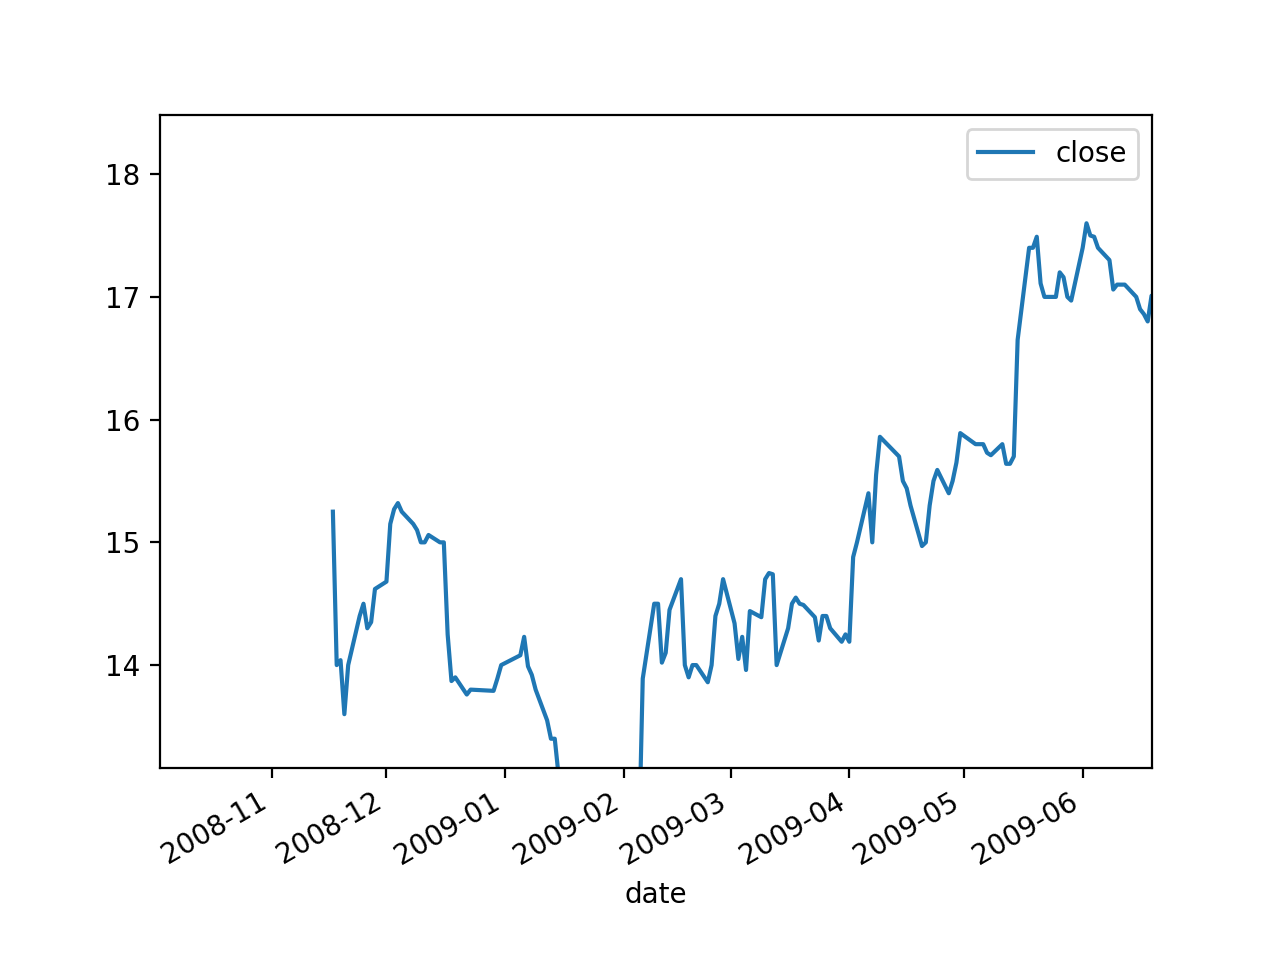

In [67]:
# tests for single stock for now
symbol = wig_20_stocks['ENEA']
symbol.plot(y=['close'])

In [75]:
def get_bollinger_bands(df, ma_type='simple', time_window=20, no_std=2, price_label='close'):
    df = df.copy()
    # central moving average
    if ma_type == 'simple':
        df.loc[:, 'central_ma'] = df[price_label].rolling(window=time_window).mean()
    elif ma_type == 'exp':
        df.loc[:, 'central_ma'] = df[price_label].ewm(span=time_window, adjust=False).mean()
    # standard deviation and remaining averages
    df.loc[:, 'ma_std'] = df['central_ma'].rolling(window=time_window).std()
    df.loc[:, 'lower_ma'] = df['central_ma'] - (no_std*df['ma_std'])
    df.loc[:, 'upper_ma'] = df['central_ma'] + (no_std*df['ma_std'])
    
    df_no_nans = df[~df['ma_std'].isnull()]
    return df_no_nans

    
df_bands = get_bollinger_bands(symbol)

print(df_bands.head(10))



             open   high    low  close  volume  central_ma    ma_std  \
date                                                                   
2009-01-15  13.40  13.40  13.01  13.10  136818     13.9895  0.243027   
2009-01-16  13.21  13.21  13.01  13.07    9181     13.8900  0.277706   
2009-01-19  13.03  13.03  12.54  12.66   43256     13.7730  0.315565   
2009-01-20  12.81  12.84  12.40  12.48   38780     13.6470  0.353481   
2009-01-21  11.72  12.35  11.69  12.30   34045     13.5495  0.388686   
2009-01-22  12.44  12.44  11.99  12.11    4505     13.4615  0.419458   
2009-01-23  12.25  12.25  11.55  11.85   34791     13.3590  0.447933   
2009-01-26  11.94  11.94  11.51  11.60    7291     13.2510  0.475809   
2009-01-27  11.64  11.74  11.54  11.60    6051     13.1410  0.502929   
2009-01-28  11.60  11.60  11.49  11.50   32591     13.0265  0.528510   

             lower_ma   upper_ma  
date                              
2009-01-15  13.503445  14.475555  
2009-01-16  13.334587  14.4454

<IPython.core.display.Javascript object>


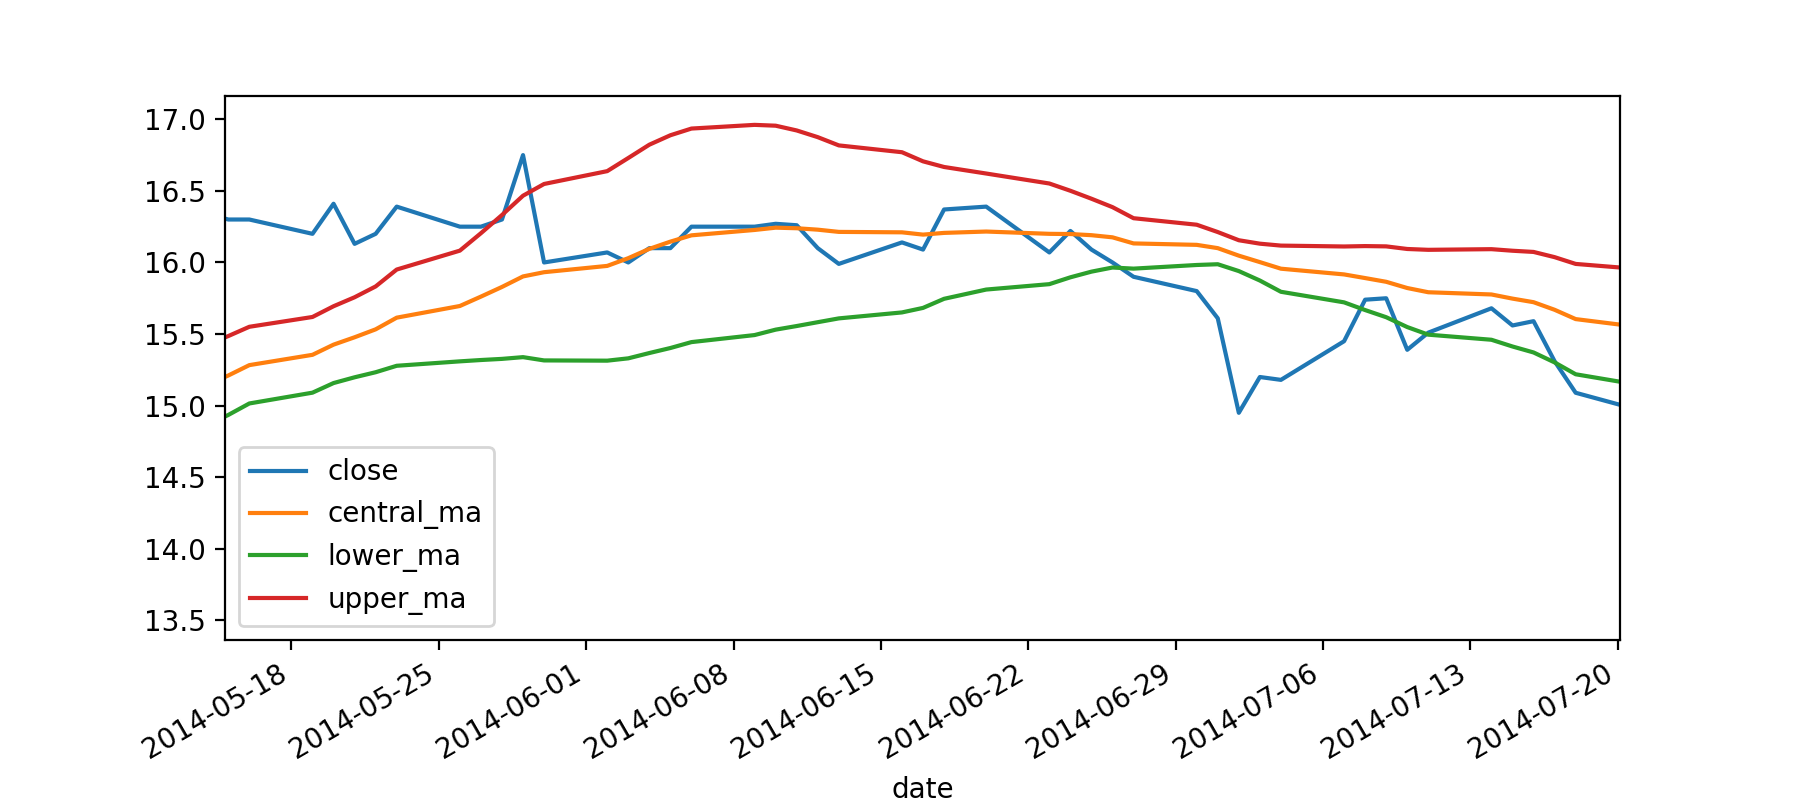

In [86]:
"""
not sure if that's waste of time but that chart could be pritier....
1) have candels for prices instead of single line  (that should be usefull everywhere)
    https://stackoverflow.com/questions/41821916/charting-candlestick-ohlc-one-minute-bars-with-pandas-and-matplotlib

2) central moving average should be dotted line
3) two bads could be solid line with semi-transparent filling within

4*) that's quite suspicious that closing price breaks bands so often... why is that... is 2 std dev to tight?
"""

df_bands.plot(y=['close', 'central_ma', 'lower_ma', 'upper_ma'], figsize=(9,4));